In [1]:
import numpy as np
import json
import gzip
import codecs
import pyBigWig
import os
from matplotlib import pyplot as plt
import scipy.stats as st
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

In [2]:
fastapath = "/users/amr1/pho4/data/genome/hg19/male.hg19.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [3]:
def checkMatch(seq, match, pos, tol):
    for idx, base in enumerate(match):
        if base == 'N' or seq[pos+idx] == base:
            continue
        if tol <= 0: return False
        else: tol -= 1
    return True

def findMatches (seq, match, pos, tol=1):
    for loc in range(pos, len(seq)-len(match)+1):
        if checkMatch(seq, match, loc, tol):
            return loc
    return -1

In [4]:
bed_path = "../data/er/tam/tam.bed.gz"
matches = {}
motif = "AGGTCANNNTGACCT"
rev_motif = "TCCAGTNNNACTGGA"
with gzip.open(bed_path, 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in matches: matches[chrm] = []
        start = int(line.strip().split('\t')[1])
        summit = start + int(line.strip().split('\t')[-1])
        end = int(line.strip().split('\t')[2])
        seq = GenomeDict[chrm][start:end].upper()
        pos = -2
        while (pos != -1):
            pos = findMatches (seq, motif, pos+2, tol=3)
            if pos != -1: matches[chrm].append((start+pos, summit))
        pos = -2
        while (pos != -1):
            pos = findMatches (seq, rev_motif, pos+2, tol=3)
            if pos != -1: matches[chrm].append((start+pos, summit))

In [5]:
distances = []
distToSummitLocs = {}
for chrm in matches:
    for idx in range(0, len(matches[chrm])):
        pos1, summit1 = matches[chrm][idx]
        for idy in range(idx+1, len(matches[chrm])):
            pos2, summit2 = matches[chrm][idy]
            dist = abs(pos1-pos2)
            if dist >= len(motif) and dist <= 80:
                distances.append(dist)
            else: continue
            if dist not in distToSummitLocs:
                distToSummitLocs[dist] = []
            distToSummitLocs[dist].append((chrm, summit1, summit2))

Text(0.5, 1.0, 'Pair distances in genome')

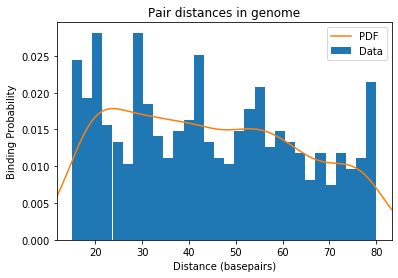

In [6]:
plt.hist(distances, density=True, bins=30, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(distances)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper right")
plt.ylabel('Binding Probability')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

Text(0.5, 1.0, 'Pair distances in genome')

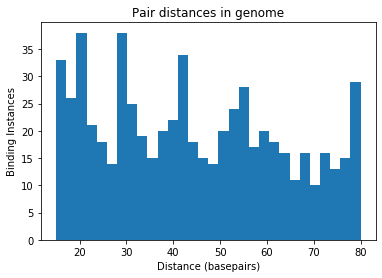

In [7]:
plt.hist(distances, density=False, bins=30, label="Data")
plt.ylabel('Binding Instances')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

Text(0.5, 1.0, 'Pair distances in genome')

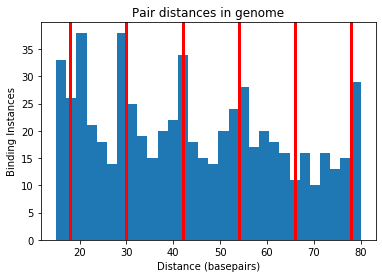

In [8]:
plt.hist(distances, density=False, bins=30, label="Data")
for vline in np.arange(18, 80, 12):
    plt.axvline(x=vline, color='red', linewidth=3.0)
plt.ylabel('Binding Instances')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

Text(0.5, 1.0, 'Pair distances in genome')

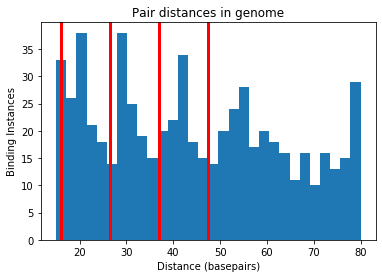

In [9]:
plt.hist(distances, density=False, bins=30, label="Data")
for vline in np.arange(16, 50, 10.5):
    plt.axvline(x=vline, color='red', linewidth=3.0)
plt.ylabel('Binding Instances')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

In [10]:
posbw = pyBigWig.open("../data/er/tam/pos.bigwig")
negbw = pyBigWig.open("../data/er/tam/neg.bigwig")

In [11]:
distToSummitVals = {}
for dist in distToSummitLocs:
    if dist > 50: continue
    distToSummitVals[dist] = []
    for chrm, summit1, summit2 in distToSummitLocs[dist]:
        posvals = np.array(posbw.values(chrm, summit1-2, summit1+2))
        where_are_NaNs = np.isnan(posvals)
        posvals[where_are_NaNs] = 0.0
        summitValPos = max(posvals)
        negvals = np.array(negbw.values(chrm, summit1-2, summit1+2))
        where_are_NaNs = np.isnan(negvals)
        negvals[where_are_NaNs] = 0.0
        summitValNeg = max(np.abs(negvals))
        summit1Val = max(summitValNeg, summitValPos)

        posvals = np.array(posbw.values(chrm, summit2-2, summit2+2))
        where_are_NaNs = np.isnan(posvals)
        posvals[where_are_NaNs] = 0.0
        summitValPos = max(posvals)
        negvals = np.array(negbw.values(chrm, summit2-2, summit2+2))
        where_are_NaNs = np.isnan(negvals)
        negvals[where_are_NaNs] = 0.0
        summitValNeg = max(np.abs(negvals))
        summit2Val = max(summitValNeg, summitValPos)

        distToSummitVals[dist].append((summit1Val+summit2Val)/2.0)

In [12]:
origX = []
for dist in distToSummitVals:
    origX.append(dist)
origX.sort()

In [13]:
bucket = 2
xvals = []
summitVals = {}
for idx in range(0, len(origX)-bucket, bucket):
    xvals.append(origX[idx])
    summitVals[origX[idx]] = distToSummitVals[origX[idx]]
    for idy in range(1, bucket):
        summitVals[origX[idx]] += distToSummitVals[origX[idx]+idy]

Text(0.5, 1.0, 'summit counts in genome')

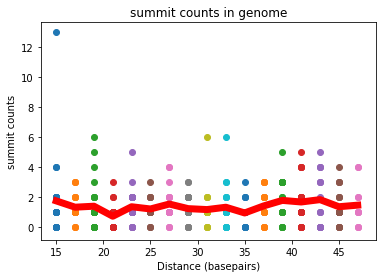

In [14]:
yvals = []
for dist in xvals:
    yvals.append(np.mean(summitVals[dist]))
for dist in xvals:
    plt.scatter([dist] * len(distToSummitVals[dist]), distToSummitVals[dist])
plt.plot(xvals, yvals, color='red', linewidth=7.0)
plt.ylabel('summit counts')
plt.xlabel('Distance (basepairs)')
plt.title("summit counts in genome")